# Loan Applications Analysis

## Introduction

### Purpose of the Analysis
The Explanatory Data Analysis on a Bank's Application Loan Data, in order to identify:
- Main trends among all applications, focusing on loan decisions, loan amount, and property types of loans.
- The differences between approved applications and rejected ones.
- Factors that significant to the loan amount, and the Model to estimate the loan amount of a new applicant.
- The low-risk model that accurately predicts loan decisions.

### Data Source
- loanapp.csv: The dataset contains data on loan applications to a bank, including various types of information on the applicant and the purpose of the loan, along with the eventual loan decision
- loanapp_desc.txt: A detailed description of the dataset columns 

### Table on Contents:

[1. Data Wrangling](#1)

[2. Desciptive Analytics](#2)

[3. Overview and Visualisations](#3)

 - [3.1. The Distribution of individual Continuous Variables](#3_1)

 - [3.2. Relationships of Continuous variable Pairs](#3_2)

 - [3.3. Associations between a Categorical variable and a Continuous one](#3_3)

 - [3.4. The relationship between more than two variables](#3_4)

[4. Unique values of Categorical variables and their frequencies](#4)

[5. Contingency Tables of potentially pairs of related Categorical variables. Statistical tests of the independence between them](#5)

[6. Subsets of Data based on specific criteria and the Descriptive Statistics on the subsets](#6)

[7. Statistical test of the Significance of the difference between the means of two subsets of the Data](#7)

[8. Tables that group the data by a certain categorical variable their summarised information](#8)

[9. A Linear Regression Model and its Output](#9)

## 1. Data Wrangling
<a name="1"></a>

In [3]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, precision_recall_curve
from statsmodels.stats.weightstats import ztest
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score


In [4]:
# Import Dataset
df = pd.read_csv(r'.\datasets\loanapp.csv')

In [5]:
# Dataset first rows
df.head()

,married,race,loan_decision,occupancy,loan_amount,applicant_income,num_units,num_dependants,self_employed,monthly_income,purchase_price,liquid_assets,mortage_payment_history,consumer_credit_history,filed_bankruptcy,property_type,gender
0,True,white,reject,1,128,74,1.0,1.0,False,4583,160.0,52.0,2,2,False,2,male
1,False,white,approve,1,128,84,1.0,0.0,False,2666,143.0,37.0,2,2,False,2,male
2,True,white,approve,1,66,36,1.0,0.0,True,3000,110.0,19.0,2,6,True,2,male
3,True,white,approve,1,120,59,1.0,0.0,False,2583,134.0,31.0,2,1,False,1,male
4,False,white,approve,1,111,63,1.0,0.0,False,2208,138.0,169.0,2,6,False,2,male


In [6]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   married                  1985 non-null   object 
 1   race                     1988 non-null   object 
 2   loan_decision            1988 non-null   object 
 3   occupancy                1988 non-null   int64  
 4   loan_amount              1988 non-null   int64  
 5   applicant_income         1988 non-null   int64  
 6   num_units                1984 non-null   float64
 7   num_dependants           1985 non-null   float64
 8   self_employed            1988 non-null   bool   
 9   monthly_income           1988 non-null   int64  
 10  purchase_price           1988 non-null   float64
 11  liquid_assets            1988 non-null   float64
 12  mortage_payment_history  1988 non-null   int64  
 13  consumer_credit_history  1988 non-null   int64  
 14  filed_bankruptcy        

### 1.1. Handle Missing Data:

In [7]:
# Nulls in each column:
print('Number of Nulls:')
for col in df.columns:
    print(f'- {col}: {df[col].isna().sum()}')

Number of Nulls:
- married: 3
- race: 0
- loan_decision: 0
- occupancy: 0
- loan_amount: 0
- applicant_income: 0
- num_units: 4
- num_dependants: 3
- self_employed: 0
- monthly_income: 0
- purchase_price: 0
- liquid_assets: 0
- mortage_payment_history: 0
- consumer_credit_history: 0
- filed_bankruptcy: 0
- property_type: 0
- gender: 14


- **Categorical values:** Given the small number of missing categorical values in `married`, `gender` from the dataset, exluding them from the dataset is the appropriate approach. If it's necessary to keep missing rows with missing values, Mode Imputation or Predicting Imputation such as k-nearest neighbors (KNN) can be used to replace the missing categorical values.
- **Numerical values:** As `num_units` and `num_dependants` are highly skewed, applying Median Imputation to replace their missing values.

In [8]:
# Dropping Nulls in `married` and `gender`
df.dropna(subset=['married', 'gender'], inplace=True)

# Impute missing values in `num_units` and `num_dependants`
df.loc[:, 'num_units'] = df['num_units'].fillna(df['num_units'].median())
df.loc[:, 'num_dependants'] = df['num_dependants'].fillna(df['num_dependants'].median())

# Dropping Duplicates
df.drop_duplicates(inplace = True)

# Rechecking the Nulls and Duplicates:
print(f' - Number of Nulls: {df.isna().sum().sum()}')
print(f' - Number of Duplicate rows: {df.duplicated().sum()}')


 - Number of Nulls: 0
 - Number of Duplicate rows: 0


### 1.2. Handle incorrect values and types:

In [9]:
# Unique values in each categorical columns:
numericals = ['loan_amount', 'applicant_income', 
              'monthly_income', 'purchase_price', 
              'liquid_assets']
print('Uniques in:')
for col in df.drop(columns=numericals):
    print(f'- {col}: {df[col].unique()}')

Uniques in:
- married: [True False]
- race: ['white' 'black' 'hispan']
- loan_decision: ['reject' 'approve']
- occupancy: [1 2 3]
- num_units: [1. 2. 3. 4.]
- num_dependants: [1. 0. 2. 4. 3. 6. 5. 8. 7.]
- self_employed: [False  True]
- mortage_payment_history: [2 1 3 4]
- consumer_credit_history: [2 6 1 3 4 5]
- filed_bankruptcy: [False  True]
- property_type: [2 1 3]
- gender: ['male' 'female']


In [10]:
# Correct data types below

# Boolean
bool_var = ['married', 'self_employed', 'filed_bankruptcy']
for b in bool_var:
    df[b] = df[b].astype('bool')
    
# Numerical
int_var = ['num_units', 'num_dependants']
for i in int_var:
    df[i] = df[i].astype('int64')
    
# Categorical
cat_var = {'race'          : ['white', 'black', 'hispan'],
           'loan_decision' : ['reject', 'approve'],
           'property_type' : [1, 2, 3],
           'gender'        : ['male', 'female']}

for c in cat_var:
    if c in ['property_type']:
        df[c] = df[c].astype(pd.CategoricalDtype(categories=cat_var[c], ordered=True))
    else:
        df[c] = df[c].astype(pd.CategoricalDtype(categories=cat_var[c]))
        
# Monthly_income to 'thousand' scale
df['monthly_income'] = round(df['monthly_income']/1000, 2)

### 1.3. Handling Outliers:

The statistics table of the numeric variables:

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
occupancy,1970.0,1.031980,0.192528,1.0,1.000,1.00,1.0,3.0
loan_amount,1970.0,143.449746,80.804505,2.0,100.000,126.00,165.0,980.0
applicant_income,1970.0,84.887310,87.422673,0.0,48.000,64.00,88.0,972.0
num_units,1970.0,1.122843,0.438308,1.0,1.000,1.00,1.0,4.0
num_dependants,1970.0,0.772081,1.105567,0.0,0.000,0.00,1.0,8.0
monthly_income,1970.0,5.201944,5.290354,0.0,2.880,3.81,5.6,81.0
purchase_price,1970.0,196.659861,128.595881,25.0,129.225,163.00,225.0,1535.0
liquid_assets,1970.0,4662.009157,67447.715172,0.0,19.725,38.00,83.0,1000000.0
mortage_payment_history,1970.0,1.707107,0.556599,1.0,1.000,2.00,2.0,4.0
consumer_credit_history,1970.0,2.114721,1.666153,1.0,1.000,1.00,2.0,6.0


 `liquid_assets`, `loan_amount`, `applicant_income`, `monthly_income`, `purchase_price` contain extreme Outliers that should be excluded to improve the reliability of the Analysis and reduce Statistical Distortion:

In [12]:
def drop_outlier(data, field):
    '''This function excludes the rows with extreme outlier in a dataframe's column

    Arguments:
        data  -- the dataframe
        field -- the feild that contains outliers
        
    Returns:
        output_data -- the dataframe with excluded outliers
    '''

    #Calculate Q1, Q3, and IQR
    Q1 = data[field].quantile(0.25)
    Q3 = data[field].quantile(0.75)
    IQR = Q3 - Q1

    #Calculate the lower and upper bounds for extreme outliers
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    #Filter the DataFrame to exclude extreme outliers
    output_data = data[(data[field] >= lower_bound) & (data[field] <= upper_bound)]
    
    return output_data
    
# Exclude the Outliers in 'loan_amount', 'applicant_income', 'monthly_income', 'purchase_price', 'liquid_assets'
for i in ['loan_amount', 'applicant_income', 
          'monthly_income', 'purchase_price',
          'liquid_assets']:
    df = drop_outlier(df, i)

In [13]:
# Export Dataset for BI
df.to_csv("loan_applications_BI.csv", index = False)

## 2.  Descriptive Statistics
<a name="2"></a>

### 2.1. Statistics Table of the Dataset

In [14]:
# General Statistics Table
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
married,1717,2,True,1120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,1717,3,white,1434,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_decision,1717,2,approve,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupancy,1717.0,NaN,NaN,NaN,1.025044,0.177267,1.0,1.0,1.0,1.0,3.0
loan_amount,1717.0,NaN,NaN,NaN,130.387303,50.786079,2.0,100.0,125.0,153.0,352.0
applicant_income,1717.0,NaN,NaN,NaN,65.817705,26.396364,4.0,48.0,61.0,78.0,183.0
num_units,1717.0,NaN,NaN,NaN,1.126383,0.439574,1.0,1.0,1.0,1.0,4.0
num_dependants,1717.0,NaN,NaN,NaN,0.727432,1.068307,0.0,0.0,0.0,1.0,8.0
self_employed,1717,2,False,1532,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monthly_income,1717.0,NaN,NaN,NaN,4.107851,1.941999,0.0,2.77,3.62,4.95,12.17


### 2.2. Statistics Table of `approve` Loans:

In [15]:
# Statistic table of Approved Loans:
approval_stats = df[df['loan_decision'] == 'approve'].describe(include='all').T
approval_stats

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
married,1497,2,True,991,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,1497,3,white,1302,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_decision,1497,1,approve,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupancy,1497.0,NaN,NaN,NaN,1.022044,0.164074,1.0,1.0,1.0,1.0,3.0
loan_amount,1497.0,NaN,NaN,NaN,130.131597,50.76135,2.0,100.0,125.0,153.0,352.0
applicant_income,1497.0,NaN,NaN,NaN,66.237141,26.211817,4.0,48.0,61.0,79.0,183.0
num_units,1497.0,NaN,NaN,NaN,1.102872,0.398994,1.0,1.0,1.0,1.0,4.0
num_dependants,1497.0,NaN,NaN,NaN,0.712759,1.059868,0.0,0.0,0.0,1.0,8.0
self_employed,1497,2,False,1347,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monthly_income,1497.0,NaN,NaN,NaN,4.120574,1.921855,0.0,2.78,3.64,4.97,12.0


### 1.3 Statistics Table of `recject` Loans:

In [16]:
# Statistic table of Declined Loans:
approval_stats = df[df['loan_decision'] != 'approve'].describe(include='all').T
approval_stats

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
married,220,2,True,129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,220,3,white,132,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_decision,220,1,reject,220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupancy,220.0,NaN,NaN,NaN,1.045455,0.248699,1.0,1.0,1.0,1.0,3.0
loan_amount,220.0,NaN,NaN,NaN,132.127273,51.035955,9.0,100.0,123.5,161.25,320.0
applicant_income,220.0,NaN,NaN,NaN,62.963636,27.511534,10.0,43.0,57.0,75.0,180.0
num_units,220.0,NaN,NaN,NaN,1.286364,0.630138,1.0,1.0,1.0,1.0,4.0
num_dependants,220.0,NaN,NaN,NaN,0.827273,1.121472,0.0,0.0,0.0,2.0,4.0
self_employed,220,2,False,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monthly_income,220.0,NaN,NaN,NaN,4.021273,2.076448,0.0,2.6475,3.53,4.785,12.17


In [17]:
# Number of loans with Amount < Purchase Price:
loans_less = df[df['loan_amount'] <= df['purchase_price']].shape[0]
print(f"Percentage of loan that less or equal than purchase price: {loans_less*100/df.shape[0]}")

Percentage of loan that less or equal than purchase price: 98.60221316249272


In [18]:
loans_less_50 = df[df['loan_amount'] >= 0.5*df['purchase_price']].shape[0]
print(f"Percentage of loan that less or equal than purchase price: {loans_less_50*100/df.shape[0]}")

Percentage of loan that less or equal than purchase price: 94.05940594059406


In [19]:
loans_less_70 = df[df['loan_amount'] >= 0.7*df['purchase_price']].shape[0]
print(f"Percentage of loan that less or equal than purchase price: {loans_less_70*100/df.shape[0]}")

Percentage of loan that less or equal than purchase price: 77.8683750728014


### Main trends:

1. **Married Status:** Most of applicants are married, with **1308/1985** applicants.
2. **Race:** Majority of applicants are `White`, with **1680/1988** applicants.
3. **Self-Employment:** Majority of appicants are NOT `Self-Employed`, with **1731/1988** applicants.
4. **Gender:**: Majority of appicants race are `Male`, with **1605/1974** applicants.
5. **Loan Approvals**: **89%** (**1744/1988**) applications were approved.  
6. **Loan Amount**: **94%** of loans are larger than half of `Purchase Price`.

### Trends between Approved and Rejected Loan Applications:


|                                                    |       **Approved loans**       |       **Rejected loans**     |
|----------------------------------------------------|--------------------------------|------------------------------|
|                         Count                      |              1744              |             244              |
|      Average credit history on consumer stuff      |              1.93              |             3.38	         |
|    Average credit history on mortgage payments     |              1.68              |             1.89             |
|       Average applicant income (thousands)         |              83.9              |             90.36            |
|              Average monthly income                |              5248              |             6016             |
|               Average loan amount                  |              143.57            |             141.1            |
|               Average Liquid Assets                |              4679.43           |             4197.87          |
|          Non-White Applicant Percentage            |              12.5%             |             36.89%           |


## 3. Overview and Visualisations
<a name="3"></a>

### 3.1 Distributions of Continuous Variables
<a name="3_1"></a>

Countinuous variables:
1. `loan_amount`: loan amount (in thousands)
2. `applicant_income`: applicant income (in thousands)
3. `monthly_income`: total monthly income
4. `purchase_price`: purchase price (in thousands)
5. `liquid_assets`: liquid assets (in thousands)

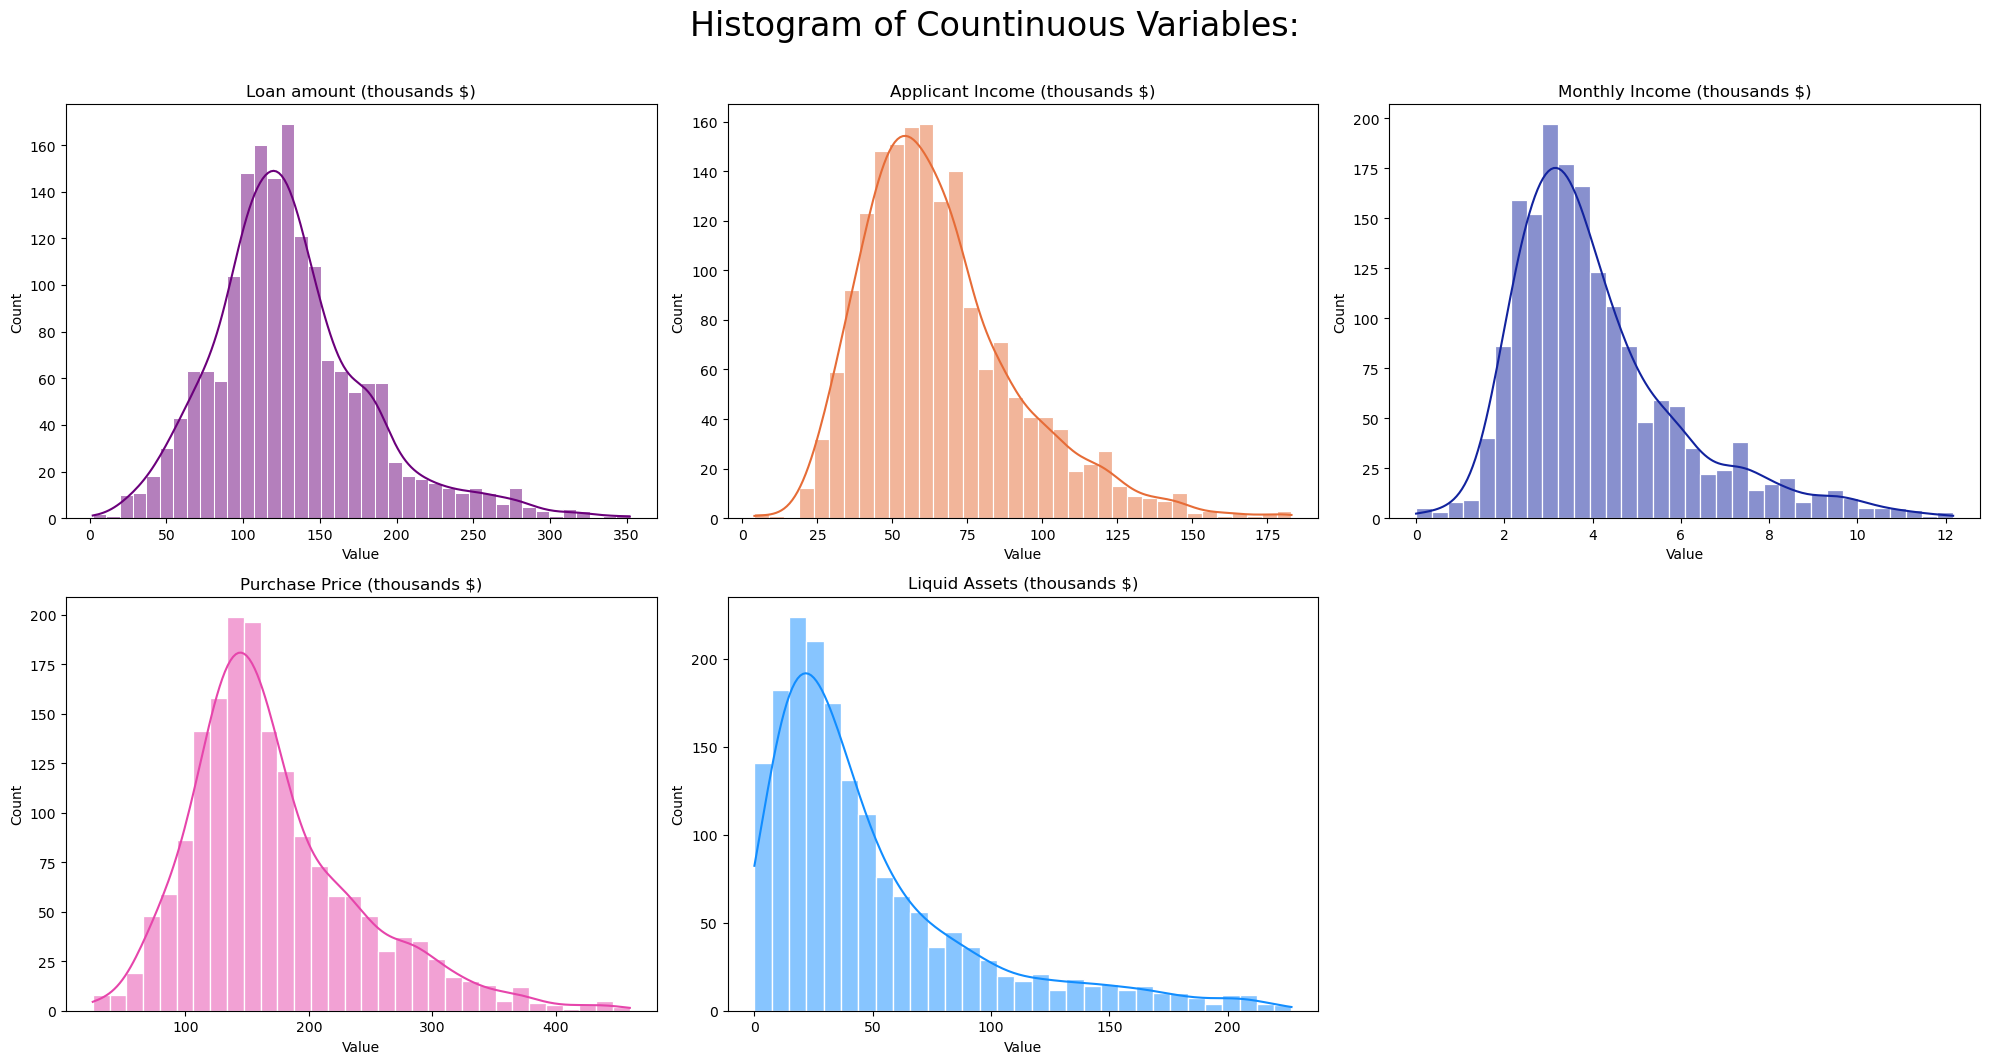

In [20]:
# Countinuous variables:
continuous = ['loan_amount',
              'applicant_income',
              'monthly_income',
              'purchase_price',
              'liquid_assets']

# Names of each distribution subplot 
continuous_name = ['Loan amount (thousands $)',
                   'Applicant Income (thousands $)',
                   'Monthly Income (thousands $)',
                   'Purchase Price (thousands $)',
                   'Liquid Assets (thousands $)']

# List of different colors in Hex
colors = ['#6B007B', '#E66C37',  '#12239E', '#E645AB', '#118DFF']

# Create 5 histograms in 2x3 figure:
fig, axes = plt.subplots(2, 3, figsize = (20, 10))
axes = axes.flatten()  # Flatten the 2x3 array of axes

# Visualise the plots
for i, (cont, clr) in enumerate(zip(continuous, colors)):
    sns.histplot(df[cont], 
                 kde = True, 
                 ax = axes[i], 
                 color = clr, 
                 edgecolor = 'white')
    axes[i].set_title(continuous_name[i])
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')

# Turn off the unused subplots:
for j in range(len(continuous), len(axes)):
    axes[j].axis('off')
    
# Adjust layout
plt.tight_layout()

# Figure title
fig.suptitle('Histogram of Countinuous Variables:',
             fontsize = 24, y = 1.06)
# Show plot
plt.show()

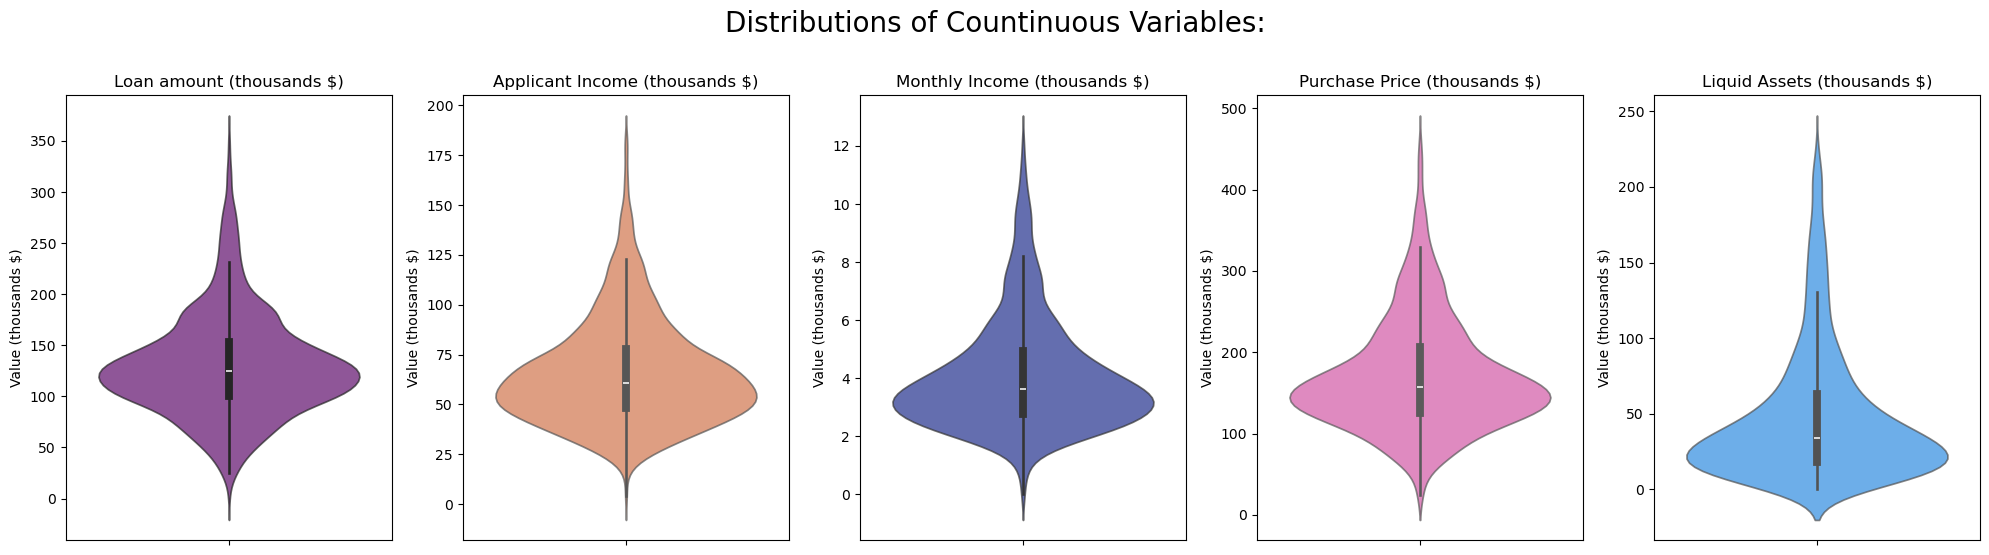

In [21]:
# Figure of 5 side-by-side violin plots
fig, axes = plt.subplots(1, 5, figsize = (20, 5))

# Visualise the plots
for i, (cont, clr) in enumerate(zip(continuous, colors)):
    sns.violinplot(df[cont], ax = axes[i], color = clr, alpha = 0.7)
    axes[i].set_title(continuous_name[i])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Value (thousands $)')
    
# Adjust layout
plt.tight_layout()

# Figure title
fig.suptitle('Distributions of Countinuous Variables:',
             fontsize = 20, y = 1.1)
# Show plot
plt.show()

#### Comments:
- **Skewness:** All distributions of continuous variables `loan_amount`, `applicant_income`, `monthly_income`, `purchase_price`, `liquid_assets` are **right-skewed**. Suggesting highest number of applicants come from the low to middle ranges of those variables
- **Loan Amount:** Majority of Loans are around **100,000** to **150,000 USD** 
- **Income:** Majority of Appicant's income are around **40,000** to **70,000 USD**

### 3.2 Relationships of Continuous variable pairs
<a name="3_2"></a>

Countinuous variables:
1. `loan_amount`: loan amount (in thousands)
2. `applicant_income`: applicant income (in thousands)
3. `monthly_income`: total monthly income
4. `purchase_price`: purchase price (in thousands)
5. `liquid_assets`: liquid assets (in thousands)

#### Pairplot between Countinuous Variables:

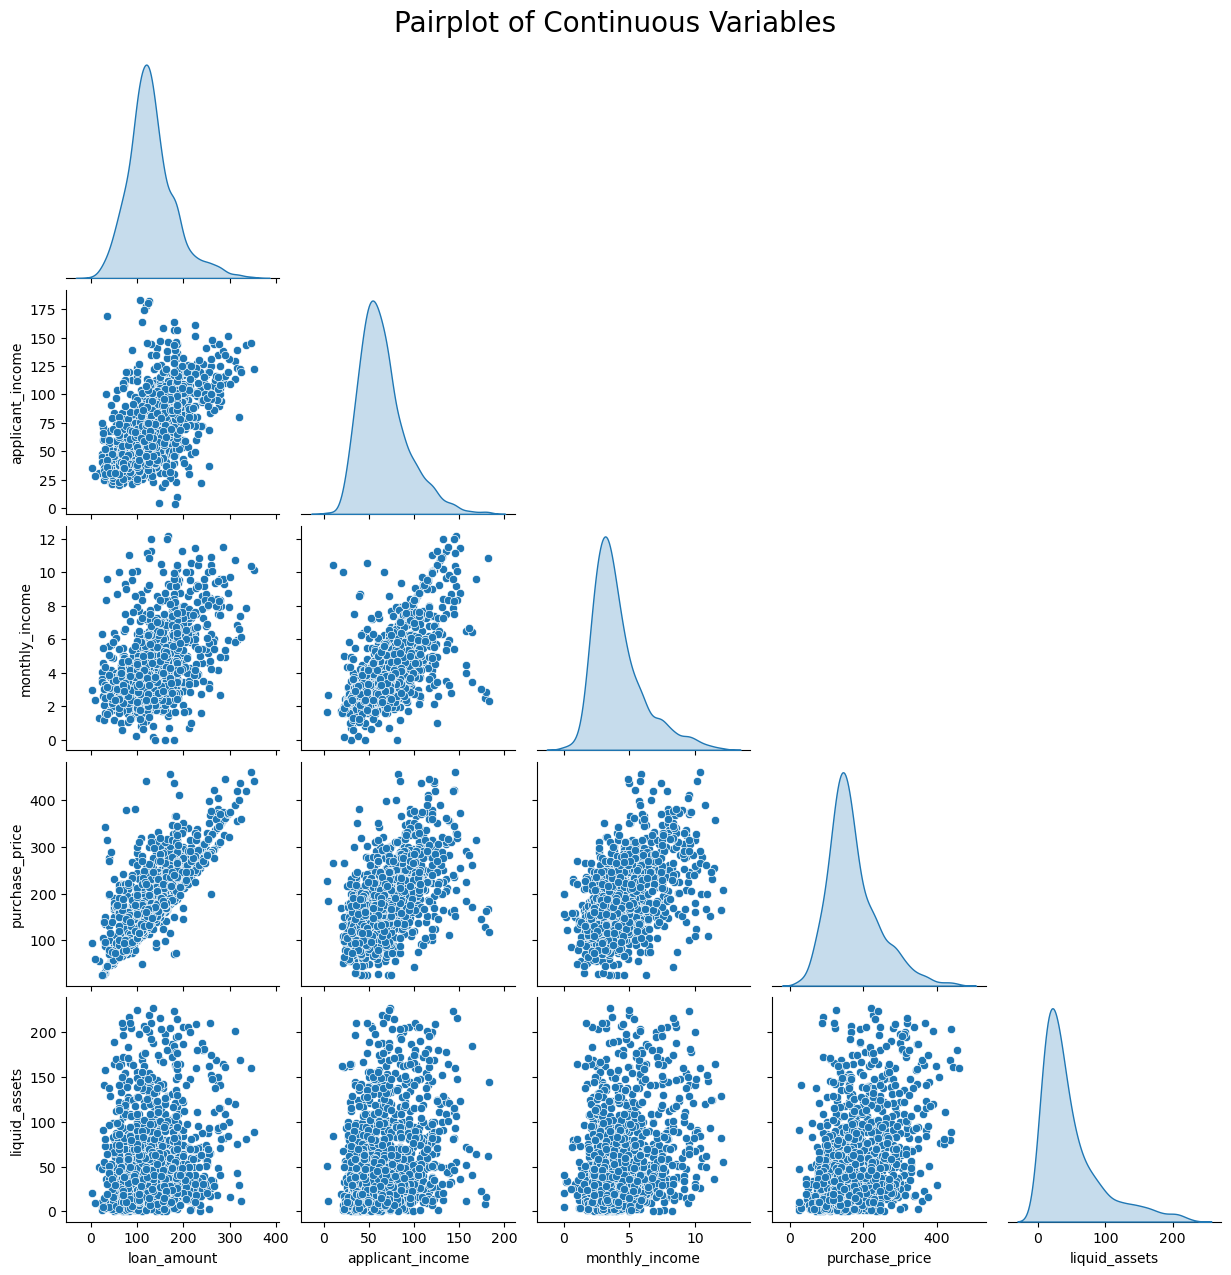

In [22]:
# Create pair plot
pairplot = sns.pairplot(df[continuous], diag_kind='kde', corner=True)

# Display the plot with title
pairplot.fig.suptitle('Pairplot of Continuous Variables', fontsize = 20, y=1.02)
plt.show()

- It looks like Income variables (`monthly_income` and `applicant_income`) are positively correlated with `loan_amount` and `purchase_price`.
- `purchase_price` also seems to be correlated with `loan_amount`.
  
However, these relationships are not clear due to overcrowded scatter plots. Thus, visualise scatter plots with a sample of the dataset to illustrate clearer relationships:

#### Scatter plots of the sampled applicants' monthly income (`monthly_income`) against their loan amount (`loan_amount`).

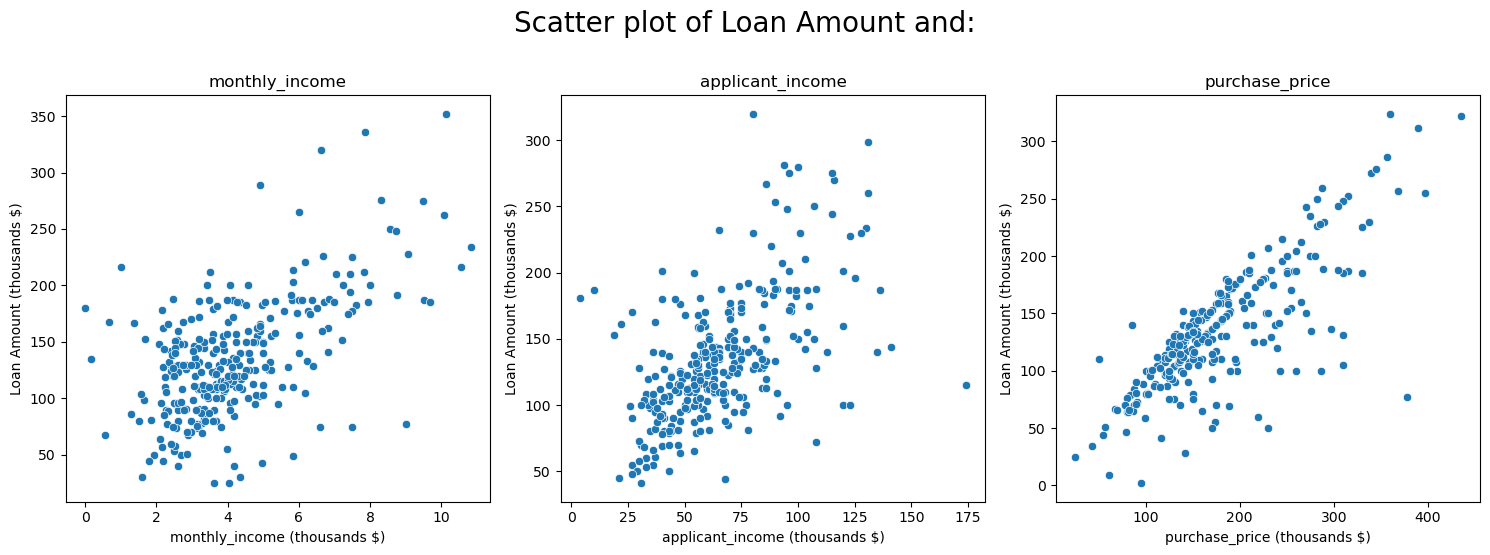

In [23]:
# Figure of 5 side-by-side violin plots
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

# Visualise the scatter plots of these variables below vs. loan_amount
for i, cnt in enumerate(['monthly_income', 'applicant_income', 'purchase_price']):
    sns.scatterplot(data = df.sample(300), 
                x = cnt, 
                y = 'loan_amount', 
                ax = axes[i])
    axes[i].set_title(cnt)
    axes[i].set_xlabel(f"{cnt} (thousands $)")
    axes[i].set_ylabel('Loan Amount (thousands $)')
    
# Adjust layout
plt.tight_layout()

# Figure title
fig.suptitle("Scatter plot of Loan Amount and:",
             fontsize = 20, y = 1.1)
# Show plot
plt.show()

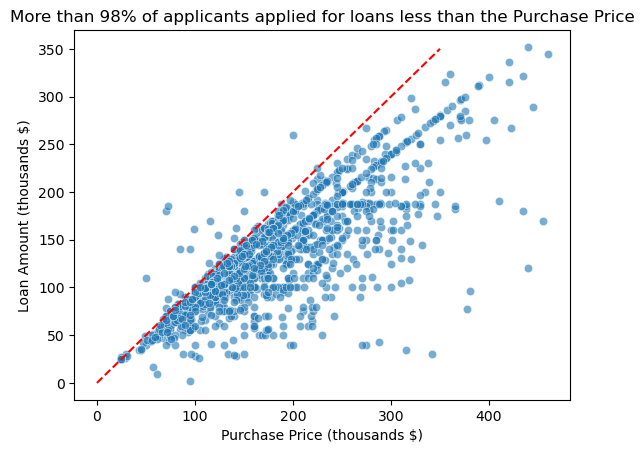

In [24]:
sns.scatterplot(data = df, 
                x = 'purchase_price', 
                y = 'loan_amount',
                alpha = 0.6)
# Add 45-degree line
plt.plot([0, 350], [0, 350], color='red', linestyle='--')

plt.title('More than 98% of applicants applied for loans less than the Purchase Price')
plt.xlabel('Purchase Price (thousands $)')
plt.ylabel('Loan Amount (thousands $)')
plt.show()

#### Comments:
1. **Aplicant's Loan Amount and Purchase Price:** Applicant have the tendency to apply for loans less or close to Purchase Price.
2. **Aplicant's Loan Amount and Income:** As the Applicant's Income or Monthly Income increase, their loan amount also increases.
3. Most applicants (more than 98%) applied for loan less than `Purchase price`

### 3.3 Associations between Categorical variables and a Continuous ones
<a name="3_3"></a>

#### Averages between `Approved` Applicants and `Rejected` Applicants: 

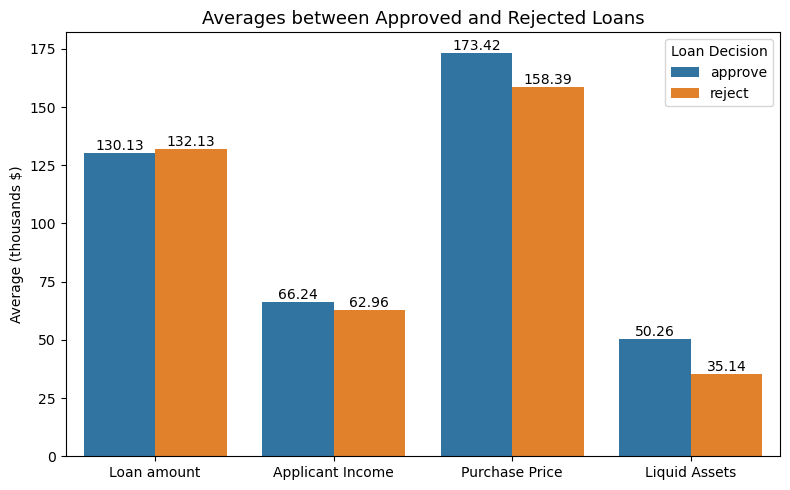

In [25]:
# group the averages of "loan_amount", "applicant_income", "purchase_price", "liquid_assets" by loan decisions
df_avg = df.groupby("loan_decision", observed = False)[["loan_amount", 
                                                        "applicant_income", 
                                                        "purchase_price", 
                                                        "liquid_assets"]].mean().reset_index()

continuous_name = ['Loan amount',
                   'Applicant Income',
                   'Purchase Price',
                   'Liquid Assets']

# Melt the DataFrame for Seaborn
df_melted = df_avg.melt(id_vars = "loan_decision", 
                        var_name = "Metric", 
                        value_name = "Average Value")

# Create the bar plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data = df_melted,
    x = "Metric",
    y = "Average Value",
    hue = "loan_decision",
    hue_order = ["approve", "reject"]
)

# Include data label on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize =10, color = 'black')

# Customize the plot
plt.title("Averages between Approved and Rejected Loans" , fontsize = 13)
plt.ylabel("Average (thousands $)")
plt.xlabel("")
plt.xticks(
    ticks = [0, 1, 2, 3],
    labels = continuous_name,
)
plt.legend(title="Loan Decision")
plt.tight_layout()
plt.show()
    

#### Box plots of Applicant `Income`, by `Gender`:

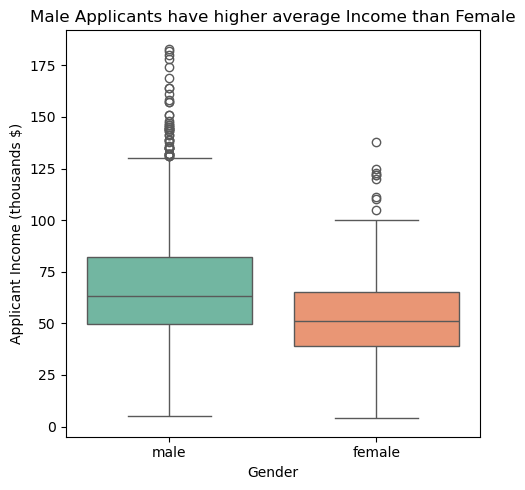

In [26]:
# Create the boxplot
plt.figure(figsize=(5, 5))
sns.boxplot(data=df, x='gender', y='applicant_income', 
            hue = 'gender', whis=1.5, palette="Set2")

plt.title('Male Applicants have higher average Income than Female')
plt.xlabel('Gender')
plt.ylabel('Applicant Income (thousands $)')
plt.tight_layout()

# Show the plot
plt.show()

#### Comments:
- There are no significant differences in the average of Loan Amount and Applicant Income between Approved and Rejected loans.
- Conversely, Purchase price and Liquid Assets Averages of Approved loans are considerably higher than those of Rejected loans.
- Generally, Male Applicants have higher income than that of Females

### 3.4 The Relationship between more than two variables
<a name="3_4"></a>

#### The Scatter plot of Applicant Income and Loan Amount, based on their Loan Decisions

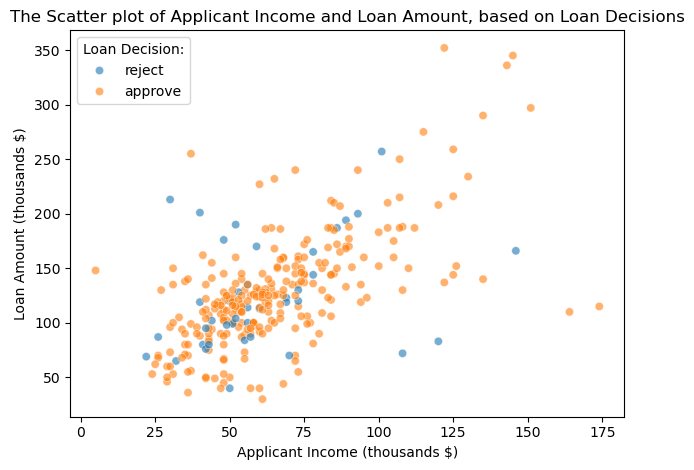

In [27]:
# Scatter plot of 
sns.scatterplot(data = df.sample(300, random_state = 42), 
                x = 'applicant_income', 
                y = 'loan_amount', 
                alpha = 0.6, 
                hue = 'loan_decision')

# Customize the plot
plt.title('The Scatter plot of Applicant Income and Loan Amount, based on Loan Decisions')
plt.xlabel('Applicant Income (thousands $)')
plt.ylabel('Loan Amount (thousands $)')
plt.legend(title = 'Loan Decision:')
plt.tight_layout()
plt.show()

#### Heatmaps of of `approve` and `reject` applications, based on Consumer Credit and Mortage Pay History:

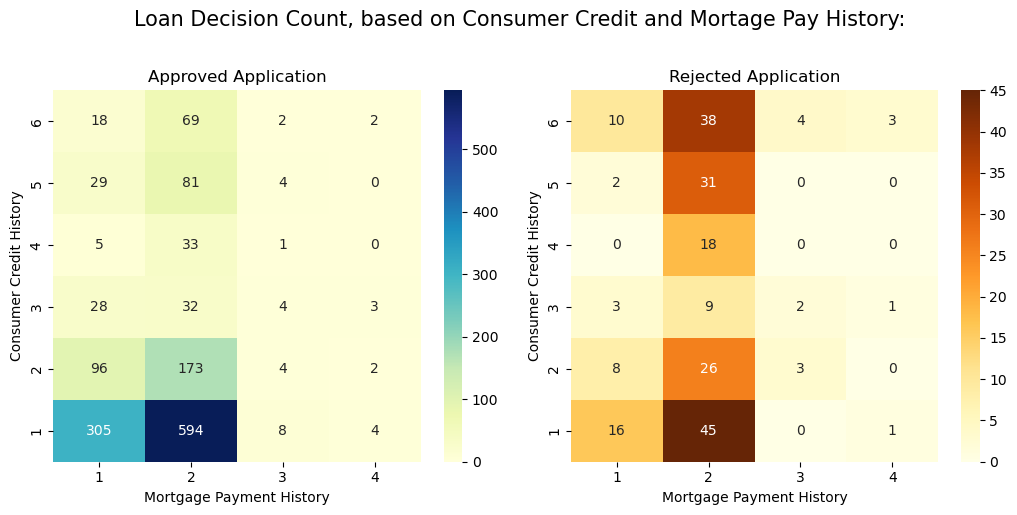

In [28]:
# Create a pivot table for the count of reject and approval based on credits history
def pivot_table(data, field, condition): 
    '''This function performs pivot table returning number of reject or approvals 
       based on consumer_credit_history and mortage_payment_history

    Arguments:
        data        : imput dataframe
        field       : the counted variable, e.g: loan_decision, etc.
        condition   : the categorical values, e.g: approve, reject, etc.

    Returns:
        the pivoted dataframe
    '''
    out = data[data[field] == condition].pivot_table(
        values= field, 
        index='consumer_credit_history', 
        columns='mortage_payment_history', 
        aggfunc='count',
        observed = False)
    out.fillna(0, inplace = True)
    return out

#Get the pivot tables for 'approve' and 'reject'
pivot_table_reject = pivot_table(df, 'loan_decision', 'reject')
pivot_table_approve = pivot_table(df, 'loan_decision', 'approve')

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10.5, 5))

# Plot heatmap for approved loans
axes[0] = sns.heatmap(pivot_table_approve, 
                      annot=True, 
                      fmt='.0f', 
                      cmap='YlGnBu', 
                      ax = axes[0])
axes[0].invert_yaxis()
axes[0].set_title('Approved Application')
axes[0].set_xlabel('Mortgage Payment History')
axes[0].set_ylabel('Consumer Credit History')


#plot heatmap for rejected loans:
axes[1] = sns.heatmap(pivot_table_reject, 
                      annot=True, 
                      fmt='.0f', 
                      cmap='YlOrBr', 
                      ax = axes[1])
axes[1].invert_yaxis()
axes[1].set_title('Rejected Application')
axes[1].set_xlabel('Mortgage Payment History')
axes[1].set_ylabel('Consumer Credit History')

fig.suptitle('Loan Decision Count, based on Consumer Credit and Mortage Pay History:', 
             fontsize = 15, 
             y = 1.02)
plt.tight_layout()
plt.show()

#### Comments: 
- Though Loan amount and Applicant Income are positively correlated, there is no clear pattern between their values and whether or not a loan is approved or not.
- The Majority of both Approved and Rejected Loans have their Mortage Payment History of 2. However, there is no clear pattern in the heatmaps regarding the effects of Consumer Credit and Mortage Payment History on the Loan Decision

### 3.5. Unique values of a Categorical variables and their frequencies
<a name="4"></a>

In [29]:
#categorical variables
categoricals = ['married', 'race', 'loan_decision', 
                'self_employed', 'filed_bankruptcy', 
                'property_type', 'gender'] 

# show unique values and their frequency 
for cat in categoricals:
    print(f'\nUniques and freqencies of {cat}:')
    print(df[cat].value_counts())


Uniques and freqencies of married:
married
True     1120
False     597
Name: count, dtype: int64

Uniques and freqencies of race:
race
white     1434
black      182
hispan     101
Name: count, dtype: int64

Uniques and freqencies of loan_decision:
loan_decision
approve    1497
reject      220
Name: count, dtype: int64

Uniques and freqencies of self_employed:
self_employed
False    1532
True      185
Name: count, dtype: int64

Uniques and freqencies of filed_bankruptcy:
filed_bankruptcy
False    1601
True      116
Name: count, dtype: int64

Uniques and freqencies of property_type:
property_type
2    1197
1     369
3     151
Name: count, dtype: int64

Uniques and freqencies of gender:
gender
male      1395
female     322
Name: count, dtype: int64


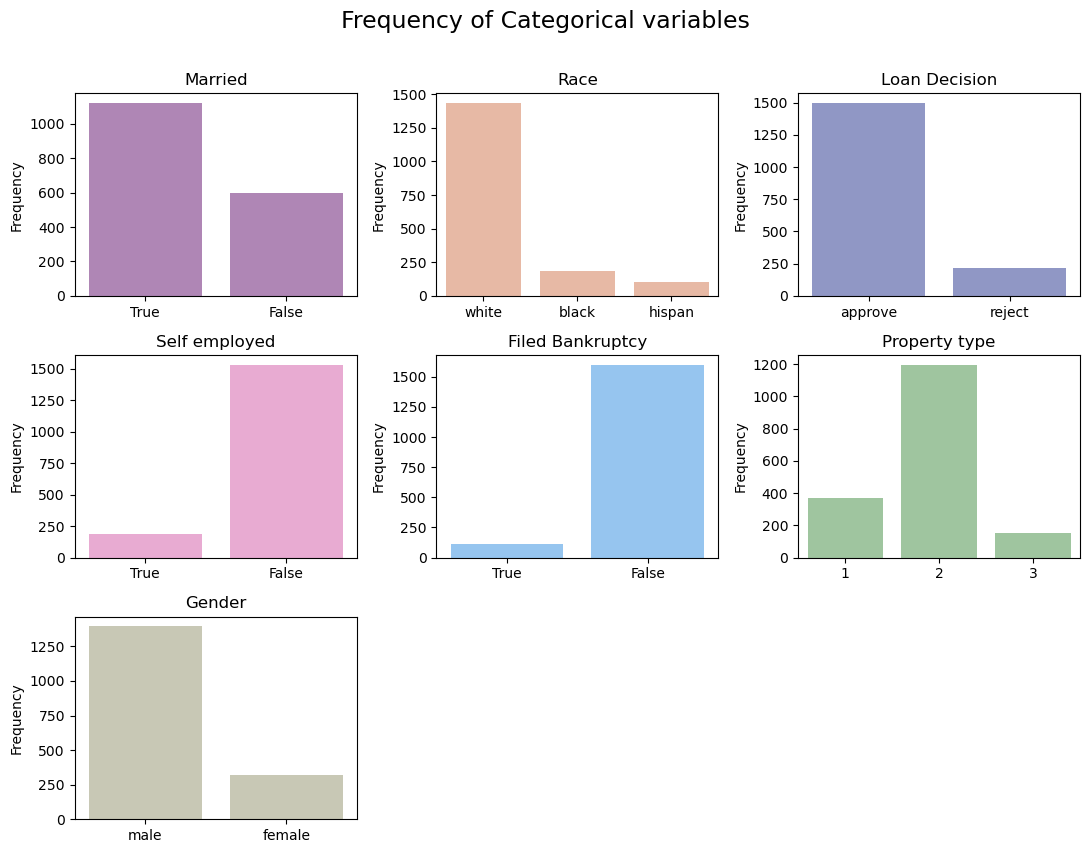

In [30]:
# names of categorical variables
categorical_name = ['Married', 'Race',
                    'Loan Decision', 'Self employed',
                    'Filed Bankruptcy', 'Property type',
                    'Gender'] 

# colours used specified in Hex
colors = ['#6B007B', '#E66C37',  
          '#12239E', '#E645AB', 
          '#118DFF', '#339933', 
          '#999966']

# Create a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize = (11, 8))
axes = axes.flatten()  # Flatten the 3x3 array of axes


# Loop through fields and plot
for i, field in enumerate(categoricals):
    if field in ['married', 'self_employed', 'filed_bankruptcy']:
        sns.countplot(x = df[field], 
                      ax = axes[i], 
                      color = colors[i], 
                      order = ['True', 'False'], 
                      alpha = 0.5)
    elif field == 'loan_decision':
        sns.countplot(x = df[field], 
                      ax = axes[i], 
                      color = colors[i], 
                      order = ['approve', 'reject'], alpha = 0.5)
    else:
        sns.countplot(x = df[field], 
                      ax = axes[i], 
                      color = colors[i], 
                      alpha = 0.5)
    # Add numbers above the bars
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel('')
    axes[i].set_title(categorical_name[i])

# Turn off the unused subplots
for j in range(len(categoricals), len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
fig.suptitle('Frequency of Categorical variables', 
             fontsize = 17, y = 1.06)
plt.show()

#### Comments:
- **Race:** Majority of applicants are `White`, with **1680/1988** applicants.
- **Gender:**: Majority of appicants race are `Male`, with **1605/1974** applicants.
- **Loan Approvals**: **89%** (**1744/1988**) applications were approved.  
- **Property Types**: Most of Properties (**1197**) are type **2** 

## 4. Associations between Categorical variables
<a name="5"></a>

### Testing the association between The Loan Decision (`loan_decision`) and each of these below:
1. Race (`race`)
2. Gender (`gender`)
3. Self-Employment Status (`self_employed`)
4. Bankruptcy History (`filed_bankruptcy`)

Setting Up Hypotheses:

- Null Hypothesis (H0)       : `loan_decision` and the tested variable are independent (no association).
- Alternative Hypothesis (HA): There is an association between the tested variable and `loan_decision`.

Siginficance Level: 5%

In [31]:
# Testing the 2 pairs of variables
def dpd_chi_test(data, cat1, cat2):
    '''This function perform chi-squared test between two catgorical variables of a dataset

    Arguments:
        data : the dataframe
        cat1 : categorical variable #1
        cat2 -- categorical variable #2

    Returns:
        contingency_table          : the contingency table between 2 catgorical variables
        test_result (dictionary)   : chi-squared test results: 'chi2_stat', 'p_value', 'dof', 'expected'
        categoricals               : the tested categorical variables
    '''
    contingency_table = pd.crosstab(data[cat1], data[cat2])
    #Perform the Chi-Square Test of Independence
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

    test_result = {'chi2_stat': chi2_stat,
                   'p_value'  : p_value,
                   'dof'      : dof,
                   'expected': expected
                  }
    categoricals = {'cat1': cat1,
                    'cat2': cat2}
    return contingency_table, test_result, categoricals

# test between 'loan_decision' and 'gender'
loan_vs_gender_table, loan_vs_gender_test, variables_gender = dpd_chi_test(df, 'loan_decision', 'gender')

# test between 'loan_decision' and 'race'
loan_vs_race_table, loan_vs_race_test, variables_race = dpd_chi_test(df, 'loan_decision', 'race')

# test between 'loan_decision' and 'self_employed'
loan_vs_employ_table, loan_vs_employ_test, variables_employ = dpd_chi_test(df, 'loan_decision', 'self_employed')

# test between 'loan_decision' and 'filed_bankruptcy'
loan_vs_bankrupt_table, loan_vs_bankrupt_test, variables_bankrupt = dpd_chi_test(df, 'loan_decision', 'filed_bankruptcy')

### Contingency Tables:

In [32]:
print(loan_vs_gender_table)

gender         male  female
loan_decision              
reject          175      45
approve        1220     277


In [33]:
print(loan_vs_race_table)

race           white  black  hispan
loan_decision                      
reject           132     63      25
approve         1302    119      76


In [34]:
print(loan_vs_employ_table)

self_employed  False  True 
loan_decision              
reject           185     35
approve         1347    150


In [35]:
print(loan_vs_bankrupt_table)

filed_bankruptcy  False  True 
loan_decision                 
reject              170     50
approve            1431     66


### Association Test Results:

In [36]:
# Show test results:
for index, (test_result, tested_var) in enumerate([ [loan_vs_race_test, variables_race], 
                                                    [loan_vs_gender_test, variables_gender],
                                                    [loan_vs_employ_test, variables_employ],
                                                    [loan_vs_bankrupt_test, variables_bankrupt]]):
    #Display the results of the test
    print(f"\n{index+1}. Chi-Square Test Results between '{tested_var['cat1']}' and '{tested_var['cat2']}':")
    print(f"  - Chi2 Stat: {test_result['chi2_stat']}")
    print(f"  - p-value: {test_result['p_value']}")
    print(f"  - Degrees of Freedom: {test_result['dof']}")
    #print(f" - Expected Frequencies Table: \n{test_result['expected']}")

    if test_result['p_value'] < 0.05:
        print(f"  CONCLUSION: Reject Null Hypothesis. There is a significant association between '{tested_var['cat1']}' and '{tested_var['cat2']}'.")
    else:
        print(f"  CONCLUSION: Fail to Reject Null Hypothesis. There is no significant association between '{tested_var['cat1']}' and '{tested_var['cat2']}'.")


1. Chi-Square Test Results between 'loan_decision' and 'race':
  - Chi2 Stat: 107.03975958813102
  - p-value: 5.709676903787585e-24
  - Degrees of Freedom: 2
  CONCLUSION: Reject Null Hypothesis. There is a significant association between 'loan_decision' and 'race'.

2. Chi-Square Test Results between 'loan_decision' and 'gender':
  - Chi2 Stat: 0.3596335180971957
  - p-value: 0.548709840625993
  - Degrees of Freedom: 1
  CONCLUSION: Fail to Reject Null Hypothesis. There is no significant association between 'loan_decision' and 'gender'.

3. Chi-Square Test Results between 'loan_decision' and 'self_employed':
  - Chi2 Stat: 6.32049062267321
  - p-value: 0.011935060215433915
  - Degrees of Freedom: 1
  CONCLUSION: Reject Null Hypothesis. There is a significant association between 'loan_decision' and 'self_employed'.

4. Chi-Square Test Results between 'loan_decision' and 'filed_bankruptcy':
  - Chi2 Stat: 99.28743193159922
  - p-value: 2.1838958882404376e-23
  - Degrees of Freedom: 1
 

### Conclusions:
- There are significant association between a Loan Decision and an applicant's race, Self-employed status and whether or not they've filed bankruptcy.
- There is no significant association between a Loan Decision and an applicant's gender.

## 5. Comparisons between `Approved` and `Rejected` applicants from similar `Income` ranges.
<a name="6"></a>

### A new column of Applicant income ranges:
1. Less than **$50,000** (`<50`)
2. From **$50,000** to **$75,000** (`50-75`)
3. Above **$75,000** (`>75`)

In [37]:
# Create income categories:
bins = [0, 50, 75, float('inf')]  # Define the edges of the bins
labels = ['<50', '50-75', '>75']  # Define labels for the bins
df['applicant_income_range'] = pd.cut(df['applicant_income'], 
                                      bins=bins, labels=labels)

### The 2 new subsets of Applicant in the Middle income range (`50-75`), whose applications were `approve` and `reject`:

In [38]:
# applicant who income in middle range and are rejected:
mid_income_reject = df[(df['applicant_income_range'] == '50-75') & 
                       (df['loan_decision'] == 'reject')]
mid_income_reject.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
married,92,2,True,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,92,3,white,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_decision,92,1,reject,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupancy,92.0,NaN,NaN,NaN,1.032609,0.178583,1.0,1.0,1.0,1.0,2.0
loan_amount,92.0,NaN,NaN,NaN,127.347826,35.010025,55.0,105.0,123.5,142.25,255.0
applicant_income,92.0,NaN,NaN,NaN,60.923913,7.091604,51.0,56.0,59.5,68.0,75.0
num_units,92.0,NaN,NaN,NaN,1.206522,0.481254,1.0,1.0,1.0,1.0,3.0
num_dependants,92.0,NaN,NaN,NaN,0.891304,1.143126,0.0,0.0,0.0,2.0,4.0
self_employed,92,2,False,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monthly_income,92.0,NaN,NaN,NaN,3.804348,1.249001,1.0,2.93,3.655,4.715,7.25


In [39]:
# applicant who income in middle range and are approved:
mid_income_approve = df[(df['applicant_income_range'] == '50-75') & 
                       (df['loan_decision'] == 'approve')]
mid_income_approve.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
married,633,2,True,432,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,633,3,white,554,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_decision,633,1,approve,633,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupancy,633.0,NaN,NaN,NaN,1.028436,0.200822,1.0,1.0,1.0,1.0,3.0
loan_amount,633.0,NaN,NaN,NaN,125.236967,31.827225,25.0,109.0,126.0,143.0,240.0
applicant_income,633.0,NaN,NaN,NaN,62.466035,7.211928,51.0,56.0,62.0,69.0,75.0
num_units,633.0,NaN,NaN,NaN,1.082148,0.327361,1.0,1.0,1.0,1.0,3.0
num_dependants,633.0,NaN,NaN,NaN,0.707741,1.111599,0.0,0.0,0.0,1.0,8.0
self_employed,633,2,False,587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monthly_income,633.0,NaN,NaN,NaN,3.785103,1.26341,0.64,2.84,3.57,4.61,10.0


#### Comments:
1. The Average Mortage Payment History Score of Approved set is 1.75 while this of Rejected set is 1.9
2. The Average Consumer Credit History Score of Approved set is 2.01 while this of Rejected set is 3.45
3. The Average Monthly Income of Approved set is 3.79 (thousand USD) while this of Rejected set is 3.8 (thousand USD)
4. The Average Liquid Asset Value of Approved set is 45.93 (thousand USD) while this of Rejected set is 27.17 (thousand USD)

Statistical Testings should be conducted between two groups to see if these average are similar or significantly different.

### Statistical tests of the difference between the means of these groups:

### Independent z-test for the averages of  `mortage_payment_history`, `consumer_credit_history`, `monthly_income` and `liquid_assets`:
- Tested samples: Applications were `approve` and `reject`, both come from Middle income range (`50-75`) 
- Siginficance level: 5%
- Null Hypothesis (H0): Averages between two groups are similar
- Alternate Hypothesis (H1): There is a significant difference between the averages of the two groups
- Method: z-test due to the large size of subsets (>30)

In [40]:
def idp_z_test(subset1, subset2, test_data, type):
    '''This function perform independent z-test between means of two samples

    Arguments:
        subset1 -- The first sample dataframe
        subset2 -- The second sample dataframe
        test_data -- the variable of the test
        type -- types of test: 'two-side', 'larger' or 'smaller'
    '''
    results = {}
    
    # Perform z-test
    z_stat, p_value = ztest(
    subset1[test_data], 
    subset2[test_data], 
    alternative=type
    )
    results[test_data] = {'z-statistic': z_stat, 'p-value': p_value}
    
    for var, res in results.items():
        print(f"Variable: {var}")
        print(f" - z-statistic: {res['z-statistic']:.2f}")
        print(f" - p-value: {res['p-value']:.4f}")
        if res['p-value'] < 0.05:
            print(" - CONCLUSION: Significant difference in the averages")
        else:
            print(" - CONCLUSION: No significant difference in the averages")
        print()
    
# Test results for the 4 variables 'mortage_payment_history', 'consumer_credit_history', 'monthly_income', 'liquid_assets':    
print(f"Indipendent z-test for means between 'Aprove' and 'Reject' applicants from Middle Income Range (50,000-70,000):\n")
for var in ['mortage_payment_history', 'consumer_credit_history', 'monthly_income', 'liquid_assets']:
    idp_z_test(mid_income_reject, mid_income_approve, var, 'two-sided')

Indipendent z-test for means between 'Aprove' and 'Reject' applicants from Middle Income Range (50,000-70,000):

Variable: mortage_payment_history
 - z-statistic: 2.56
 - p-value: 0.0105
 - CONCLUSION: Significant difference in the averages

Variable: consumer_credit_history
 - z-statistic: 7.85
 - p-value: 0.0000
 - CONCLUSION: Significant difference in the averages

Variable: monthly_income
 - z-statistic: 0.14
 - p-value: 0.8913
 - CONCLUSION: No significant difference in the averages

Variable: liquid_assets
 - z-statistic: -4.21
 - p-value: 0.0000
 - CONCLUSION: Significant difference in the averages



In [41]:
# Test Average income between Approved and Rejected Groups:
approved = df[(df['loan_decision'] == 'approve')]
rejected = df[(df['loan_decision'] == 'reject')]

# Test results for the 4 variables 'mortage_payment_history', 'consumer_credit_history', 'applicant_income', 'liquid_assets':    
print(f"Indipendent z-test for means between 'Aprove' and 'Reject' applicants :\n")
for var in ['mortage_payment_history', 'consumer_credit_history', 'applicant_income', 'liquid_assets']:
    idp_z_test(approved, rejected, var, 'larger')

Indipendent z-test for means between 'Aprove' and 'Reject' applicants :

Variable: mortage_payment_history
 - z-statistic: -5.21
 - p-value: 1.0000
 - CONCLUSION: No significant difference in the averages

Variable: consumer_credit_history
 - z-statistic: -12.30
 - p-value: 1.0000
 - CONCLUSION: No significant difference in the averages

Variable: applicant_income
 - z-statistic: 1.72
 - p-value: 0.0429
 - CONCLUSION: Significant difference in the averages

Variable: liquid_assets
 - z-statistic: 4.71
 - p-value: 0.0000
 - CONCLUSION: Significant difference in the averages



#### Comments: 
- There are significant difference in the averages of Mortage Payment, Consumer Credit History and Liquid Assets between `approve` and `reject` Applicants from Middle income range. While for Monthly income, there is no different between two groups


## 6. Grouped tables of the data by a certain Categorical variable:
<a name="6"></a>

In [42]:
# numerical variables
num_var = ['occupancy', 'loan_amount',
           'applicant_income', 'num_units', 
           'num_dependants', 'monthly_income', 
           'purchase_price', 'liquid_assets',
           'mortage_payment_history', 
           'consumer_credit_history']

def group(data, group_variable, kind=None):
    '''This functions performs group the data by a certain categorical variable

    Arguments:
        data           : the dataframe
        group_variable : the categorical variable that groups the data

    Keyword Arguments:
        kind           : type of grouping (e.g.: mean, median, sum, count)

    Returns:
        the grouped dataframe
    '''
    
    if kind == 'mean':
        return data[num_var + [group_variable]].groupby(group_variable, observed = False).mean()
    elif kind == 'median':
        return data[num_var + [group_variable]].groupby(group_variable, observed = False).median()
    elif kind == 'sum':
        return data[num_var + [group_variable]].groupby(group_variable, observed = False).sum()
    elif kind == 'count':
        return data[num_var + [group_variable]].groupby(group_variable, observed = False).count()
    


### Grouped table of Averages by Loan Decision (`loan_decision`):

In [43]:
# Mean data group by 'loan_decision':
df_mean_loan_dec = group(data = df, 
                         group_variable = 'loan_decision',
                         kind = 'mean')
df_mean_loan_dec

,occupancy,loan_amount,applicant_income,num_units,num_dependants,monthly_income,purchase_price,liquid_assets,mortage_payment_history,consumer_credit_history
loan_decision,,,,,,,,,,
reject,1.045455,132.127273,62.963636,1.286364,0.827273,4.021273,158.394773,35.140064,1.909091,3.40000
approve,1.022044,130.131597,66.237141,1.102872,0.712759,4.120574,173.418597,50.263377,1.708751,1.95992


### Grouped table of Averages by Bankruptcy (`filed_bankruptcy`):


In [44]:
# Mean data group by 'loan_decision':
df_mean_bankrupt = group(data = df, 
                         group_variable = 'filed_bankruptcy',
                         kind = 'mean')
df_mean_bankrupt

,occupancy,loan_amount,applicant_income,num_units,num_dependants,monthly_income,purchase_price,liquid_assets,mortage_payment_history,consumer_credit_history
filed_bankruptcy,,,,,,,,,,
False,1.026234,129.854466,65.913179,1.118676,0.709557,4.107345,171.909176,49.448114,1.722049,2.012492
True,1.008621,137.741379,64.500000,1.232759,0.974138,4.114828,165.757759,32.833276,1.905172,3.965517


### Comments:
1. The average income, liquid assets and purchase prices of `approve` applications are considerably higher than `reject` ones
2. Applicants who filed Bankruptcy have significant lower average Purchase Price and Liquid Assets values than those who don't.

## 7. A Linear Regression Model that estimates `Loan Amount`
<a name="9"></a>

The Linear Regression Model to Estimate Loan amount (`loan_amount`): Predict how much of a loan an applicant likely to receive.


In [45]:
# the separate dataset for the Linear Regression model
df_linreg = df.copy()
df_linreg.drop(columns = 'applicant_income_range', inplace = True)
df_linreg.reset_index()

,index,married,race,loan_decision,occupancy,loan_amount,applicant_income,num_units,num_dependants,self_employed,monthly_income,purchase_price,liquid_assets,mortage_payment_history,consumer_credit_history,filed_bankruptcy,property_type,gender
0,0,True,white,reject,1,128,74,1,1,False,4.58,160.0,52.0,2,2,False,2,male
1,1,False,white,approve,1,128,84,1,0,False,2.67,143.0,37.0,2,2,False,2,male
2,2,True,white,approve,1,66,36,1,0,True,3.00,110.0,19.0,2,6,True,2,male
3,3,True,white,approve,1,120,59,1,0,False,2.58,134.0,31.0,2,1,False,1,male
4,4,False,white,approve,1,111,63,1,0,False,2.21,138.0,169.0,2,6,False,2,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,1982,False,white,approve,1,120,46,1,0,False,2.34,160.0,47.0,2,4,False,2,male
1713,1983,True,white,approve,1,158,96,1,0,False,5.00,176.0,15.0,2,1,False,2,male
1714,1984,True,white,approve,1,35,169,1,0,False,9.58,315.0,64.0,1,1,False,1,male
1715,1985,True,white,approve,2,225,49,2,0,True,4.16,225.0,10.0,2,1,False,3,male


###  Correlation Analysis between the response variable `loan_amount` and other predictor variables:

In [46]:
# Categorical Variables
categorical = ['race', 'loan_decision', 'property_type', 'gender']

# Creating dummy variables from categorical variables
encoder = OneHotEncoder(sparse_output=False)  
encoded_data = encoder.fit_transform(df_linreg[categorical])
encoded_df = pd.DataFrame(encoded_data, 
                          columns=encoder.get_feature_names_out(categorical))

# Reset indices to ensure alignment
df_linreg_numeric = df_linreg.drop(columns=categorical).reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

# Concatenate the numeric and encoded categorical data
df_linreg_corr = pd.concat([df_linreg_numeric, encoded_df], axis=1)

#### The Correlation Matrix:

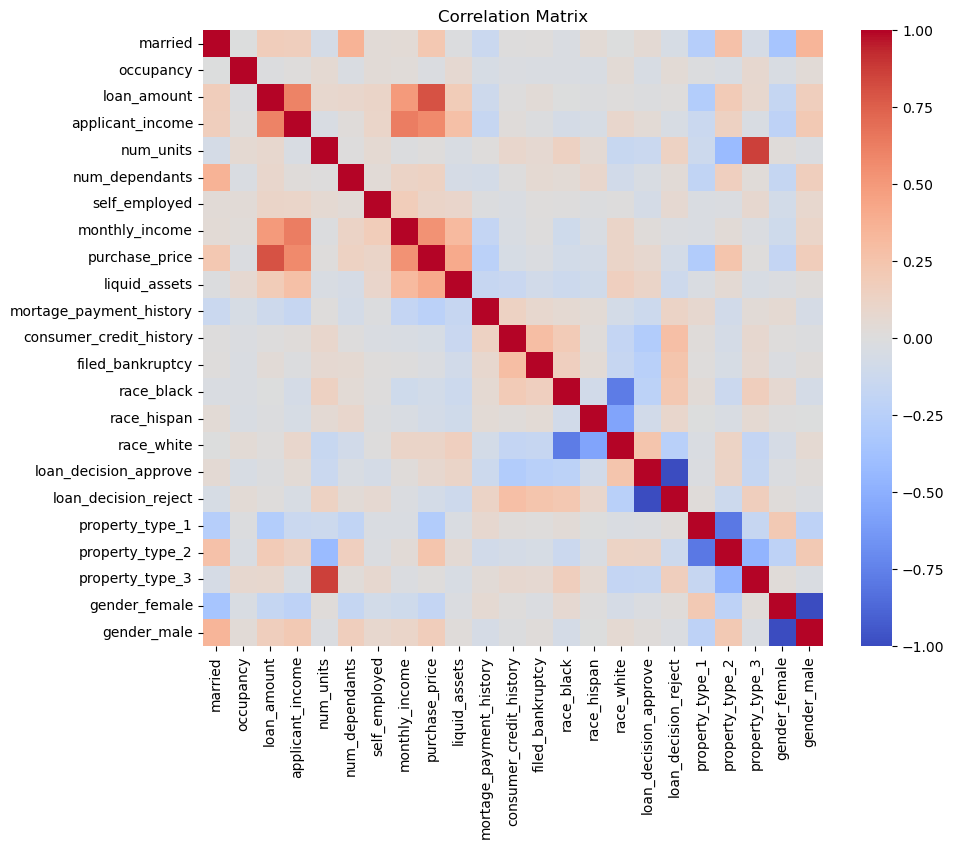

In [47]:
# Calculate the correlation matrix
corr_matrix = df_linreg_corr.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot = False, cmap='coolwarm', 
            vmin=-1, vmax=1,)
plt.title('Correlation Matrix')
plt.show()

Strong Correlations between Predictors:

1. `monthly_income` and `applicant_income`
2. `property_type_3` and `num_units`
3. `purchase_price` and `applicant_income`

Conclusion: Beside dropping some dummy variables as baselines, exclude `applicant_income` from the Linear Regression Model to address multicollinearity

### The Linear Regression Model with all possible predictors and `loan_amount` as the response variable

In [48]:
# Baseline `race_white`, `property_type_1`, `gender_male`, `loan_decision_approve` 
# as they are most common among the category
baselines = ['applicant_income', 'race_white', 
             'property_type_1', 'gender_male', 
             'loan_decision_approve']

# Exlcude the baselines
df_linreg = df_linreg_corr.drop(columns = baselines)

# Predictors (X) and Response (y)
X = df_linreg.drop(columns = 'loan_amount').astype(float)
y = df_linreg['loan_amount'] 

# Splitting data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# OLS model
X_train_OLS = sm.add_constant(X_train)
model_OLS = sm.OLS(y_train , X_train_OLS)
results_OLS = model_OLS.fit()

results_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            loan_amount   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     184.8
Date:                Mon, 23 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:05:35   Log-Likelihood:                -6515.1
No. Observations:                1373   AIC:                         1.307e+04
Df Residuals:                    1355   BIC:                         1.316e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.4563      7.262     -0.201      0.841     -15.702      12.790
married                     2.0311      1.859      1.092      0.275      -1.616       5.678
occupancy                   5.2598      4.430      1.187      0.235      -3.431      13.951
num_units                   4.3689      3.448      1.267      0.205      -2.395      11.133
num_dependants             -2.9498      0.779     -3.787      0.000      -4.478      -1.422
self_employed               0.8219      2.555      0.322      0.748      -4.190       5.833
monthly_income              3.5355      0.478      7.395      0.000       2.598       4.473
purchase_price              0.5898      0.015     40.120      0.000       0.561       0.619
liquid_assets              -0.1990      0.019    -10.232      0.000      -0.237      -0.161
mortage_payment_history     4.7982      1.514      3.168      0.002       1.827       7.769
consumer_credit_history    -0.0908      0.495     -0.184      0.854      -1.061       0.880
filed_bankruptcy            7.5260      3.259      2.309      0.021       1.132      13.920
race_black                  4.6425      2.621      1.771      0.077      -0.499       9.784
race_hispan                 8.7428      3.348      2.611      0.009       2.175      15.311
loan_decision_reject        5.1200      2.500      2.048      0.041       0.216      10.024
property_type_2             8.1089      2.073      3.912      0.000       4.043      12.175
property_type_3            11.1325      5.608      1.985      0.047       0.130      22.134
gender_female              -1.1091      2.121     -0.523      0.601      -5.270       3.052
==============================================================================
Omnibus:                      431.239   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2524.499
Skew:                          -1.332   Prob(JB):                         0.00
Kurtosis:                       9.086   Cond. No.                     2.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Conclusion:
- Significant predictors: `num_dependants`, `monthly_income`, `purchase_price`, `liquid_assets`, `mortage_payment_history`, `filed_bankruptcy`,`race_hispan`, `loan_decision_reject`, `property_type_2`, `property_type_3`

### The Most Parsimonious Linear Regression Model

In [49]:
# The kept predictors
predictors = ['num_dependants', 'monthly_income', 'purchase_price',
              'liquid_assets', 'mortage_payment_history', 'filed_bankruptcy',
               'race_hispan', 'loan_decision_reject',
              'property_type_2', 'property_type_3']

# Update the training and testing set of predictors
X_train = X_train[predictors]
X_test  = X_test[predictors]

# OLS model
X_train_OLS = sm.add_constant(X_train)
model_OLS = sm.OLS(y_train , X_train_OLS)
results_OLS = model_OLS.fit()

results_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            loan_amount   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     313.1
Date:                Mon, 23 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:05:35   Log-Likelihood:                -6519.2
No. Observations:                1373   AIC:                         1.306e+04
Df Residuals:                    1362   BIC:                         1.312e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       9.5672      3.930      2.434      0.015       1.857      17.277
num_dependants             -2.6113      0.736     -3.550      0.000      -4.054      -1.168
monthly_income              3.4672      0.468      7.408      0.000       2.549       4.385
purchase_price              0.5927      0.014     41.083      0.000       0.564       0.621
liquid_assets              -0.2009      0.019    -10.448      0.000      -0.239      -0.163
mortage_payment_history     4.4348      1.500      2.957      0.003       1.492       7.377
filed_bankruptcy            8.2558      3.143      2.627      0.009       2.091      14.421
race_hispan                 7.8259      3.309      2.365      0.018       1.334      14.318
loan_decision_reject        5.8115      2.414      2.407      0.016       1.076      10.548
property_type_2             8.6016      2.020      4.259      0.000       4.639      12.564
property_type_3            18.1301      3.169      5.721      0.000      11.913      24.347
==============================================================================
Omnibus:                      423.358   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2502.539
Skew:                          -1.301   Prob(JB):                         0.00
Kurtosis:                       9.081   Cond. No.                     1.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
# Initialize the linear regression model
linreg = LinearRegression()

# Fit the model on the training data
linreg.fit(X_train, y_train)

# Make predictions (score) on both training and test sets
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

In [51]:
# Evaluate model performance
print("Performance on Training Set:")
print(f" - Mean Squared Error (MSE): {mean_squared_error(y_train, y_train_pred):.2f}")
print(f" - R-squared (R²): {r2_score(y_train, y_train_pred):.2f}")

print("\nPerformance on Test Set:")
print(f" - Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred):.2f}")
print(f" - R-squared (R²): {r2_score(y_test, y_test_pred):.2f}")

Performance on Training Set:
 - Mean Squared Error (MSE): 779.30
 - R-squared (R²): 0.70

Performance on Test Set:
 - Mean Squared Error (MSE): 852.85
 - R-squared (R²): 0.67


#### Comments: 
- Adjusted R-Square: 0.7, meaning the model is reasonably effective at explaining the variability in the dependent variable, but there’s room for improvement.
- If a loan is applied for a type 2 property, the applicants might asked for more 8,600USD, and for more 18,130USD if it's type 3, comparing to property 1  
- To reduce the number of predictors and address multicollinearity more effectively, Dimensionality reduction method such as Principal Component Analysis (PCA) can be considered to improve the Model Output.

### Model's results on the Test set

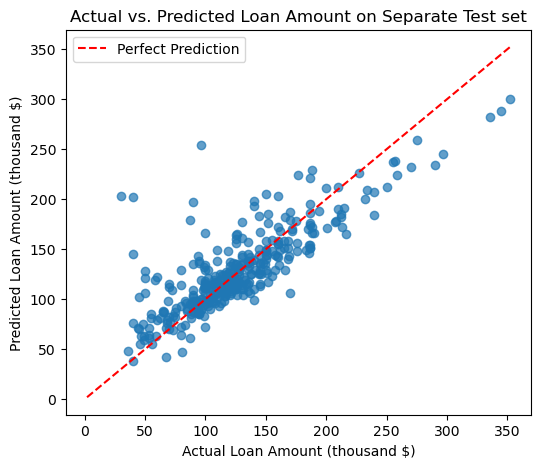

In [52]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y.min(), y.max()],
         [y.min(), y.max()], 
         color='red',
         linestyle='--', 
         label = 'Perfect Prediction')  # Line for perfect prediction  
plt.xlabel('Actual Loan Amount (thousand $)')
plt.ylabel('Predicted Loan Amount (thousand $)')
plt.title('Actual vs. Predicted Loan Amount on Separate Test set')
plt.legend(loc='upper left')
plt.show()

The distribution of Predicted vs. Actual Loan amount aligns with the Perfect Prediction Line. And the R-square on test set is 0.67 Thus, the Model is not overfitted and work well with actual data.

### Residual Analysis:

#### Residuals Scatter Plot:

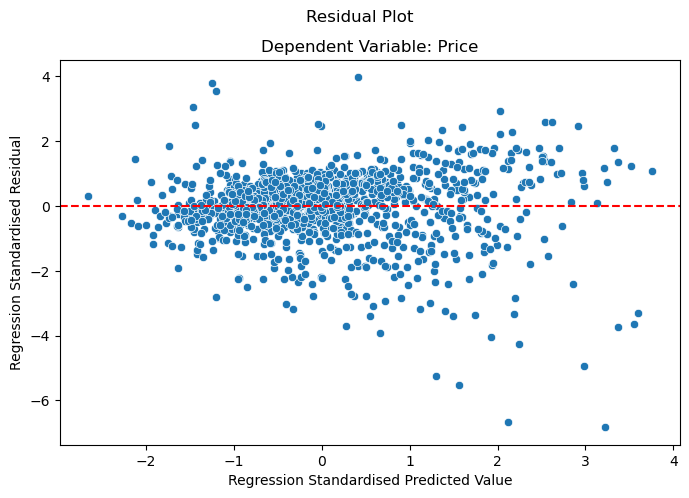

In [53]:
# Predict values and calculate residuals
residuals = y_train - y_train_pred

# Standardize the residuals
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Standardize the predicted values
standardized_predicted_values = (y_train_pred - np.mean(y_train_pred)) / np.std(y_train_pred)

# Residual plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=standardized_predicted_values, y=standardized_residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Regression Standardised Predicted Value')
plt.ylabel('Regression Standardised Residual')
plt.suptitle('Residual Plot')
plt.title('Dependent Variable: Price')
plt.show()

#### Residuals Histograms:

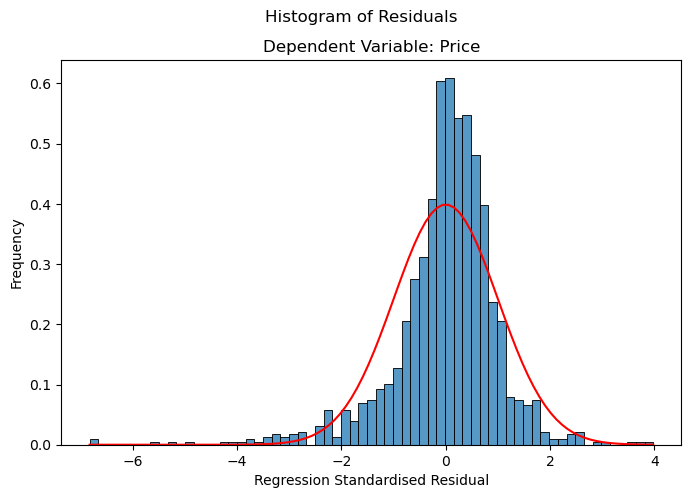

In [54]:
# Fit a normal distribution to the data
mean_res = np.mean(standardized_residuals)
std_dev_res = np.std(standardized_residuals)

# Generate x values for the normal curve
x_res = np.linspace(min(standardized_residuals), max(standardized_residuals), 100)

# Calculate the y values for the normal distribution
y_res = stats.norm.pdf(x_res, mean_res, std_dev_res)
plt.figure(figsize=(8, 5))
sns.histplot(standardized_residuals, kde=False, stat='density')
# Plot the normal curve
plt.plot(x_res, y_res, color='red', label="Normal Curve")
plt.xlabel('Regression Standardised Residual')
plt.ylabel('Frequency')
plt.suptitle('Histogram of Residuals')
plt.title('Dependent Variable: Price')
plt.show()

#### Residuals P-P Plots:

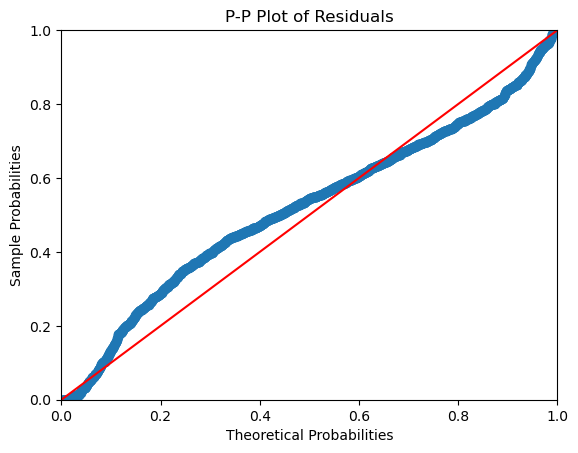

In [55]:
# Compute the standardized residuals
residuals_standardized = (residuals - np.mean(residuals)) / np.std(residuals)

# Create the P-P plot
sm.ProbPlot(residuals_standardized).ppplot(line='45')

# Add title
plt.title("P-P Plot of Residuals")
plt.show()

In [56]:
# Shapiro-Wilk Normality Test
stat, p_value = stats.shapiro(residuals_standardized)
print("Shapiro-Wilk Test: p-value =", p_value)

if p_value > 0.05:
    print("Residuals are normally distributed.")
else:
    print("Residuals are NOT normally distributed.")

Shapiro-Wilk Test: p-value = 6.146452751945111e-28
Residuals are NOT normally distributed.


#### Conclusions on the Model Residual Assumptions:
 - Assumptions 3: "The standard deviation of the residuals is the same for all values of the estimated dependent variable", and Assumption 4: "Residuals are normally distributed" fail.
 - Assumption 1 regarding linear relationship and assumption 2 regarding Independent Residuals hold.
 - To sastify the two failed assumptions, further analysis on the model's variables should be conducted. Or addressing outliers in some predictors might improve this.
 - Due to the Histogram's long left tail, it seems that the model have the tendency to predict some applicants can qualify for much more higher loan that they're actually applied for. However, there're high chances that these applicants are qualified for the high amount of loan, but they only request for the smaller amount. Given the high Adjusted R2 of the model of 0.7 on train set and 0.67 on the test set, there's confidence in the predicting ability of the Model.

## 8. Classification Model to predict `Loan Decision` 
### The Training and Validation datasets:


In [57]:
# the dataframe
df_linreg_corr.head()

baselines = ['applicant_income', 'race_white', 
             'property_type_1', 'gender_male', 
             'loan_decision_approve']

# Exlcude the baselines
df_clf = df_linreg_corr.drop(columns = baselines)

In [58]:
df_clf.head()

,married,occupancy,loan_amount,num_units,num_dependants,self_employed,monthly_income,purchase_price,liquid_assets,mortage_payment_history,consumer_credit_history,filed_bankruptcy,race_black,race_hispan,loan_decision_reject,property_type_2,property_type_3,gender_female
0,True,1,128,1,1,False,4.58,160.0,52.0,2,2,False,0.0,0.0,1.0,1.0,0.0,0.0
1,False,1,128,1,0,False,2.67,143.0,37.0,2,2,False,0.0,0.0,0.0,1.0,0.0,0.0
2,True,1,66,1,0,True,3.00,110.0,19.0,2,6,True,0.0,0.0,0.0,1.0,0.0,0.0
3,True,1,120,1,0,False,2.58,134.0,31.0,2,1,False,0.0,0.0,0.0,0.0,0.0,0.0
4,False,1,111,1,0,False,2.21,138.0,169.0,2,6,False,0.0,0.0,0.0,1.0,0.0,0.0


In [59]:
# Separate features and target variable
X = df_clf.drop('loan_decision_reject', axis=1)
y = df_clf['loan_decision_reject']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Ultilise SMOTE Oversampling Technique to for imbalance classification:

In [60]:
# Check class distribution before SMOTE
print("Class distribution before SMOTE:", dict(zip(*np.unique(y_train, return_counts=True))))
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:", dict(zip(*np.unique(y_resampled, return_counts=True))))

Class distribution before SMOTE: {0.0: 1051, 1.0: 150}
Class distribution after SMOTE: {0.0: 1051, 1.0: 1051}


### Compare Classification Models on the dataset:

In [61]:
# Classification Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_resampled, y_resampled)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    cm = confusion_matrix(y_test, y_pred)
    
    # Store results
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
        "Confusion Matrix": cm
    }


In [62]:
# Display results
results_df = pd.DataFrame(results).T
print(results_df)

                     Accuracy Precision    Recall  F1-Score   ROC-AUC  \
Logistic Regression  0.771318  0.309524  0.557143  0.397959   0.72335   
Random Forest        0.829457    0.3125  0.214286  0.254237  0.715839   
SVM                  0.546512  0.196296  0.757143  0.311765  0.705013   
KNN                  0.660853  0.185629  0.442857  0.261603  0.599039   
Decision Tree        0.784884  0.253012       0.3   0.27451  0.580493   

                           Confusion Matrix  
Logistic Regression   [[359, 87], [31, 39]]  
Random Forest         [[413, 33], [55, 15]]  
SVM                  [[229, 217], [17, 53]]  
KNN                  [[310, 136], [39, 31]]  
Decision Tree         [[384, 62], [49, 21]]  


### ROC Curves:

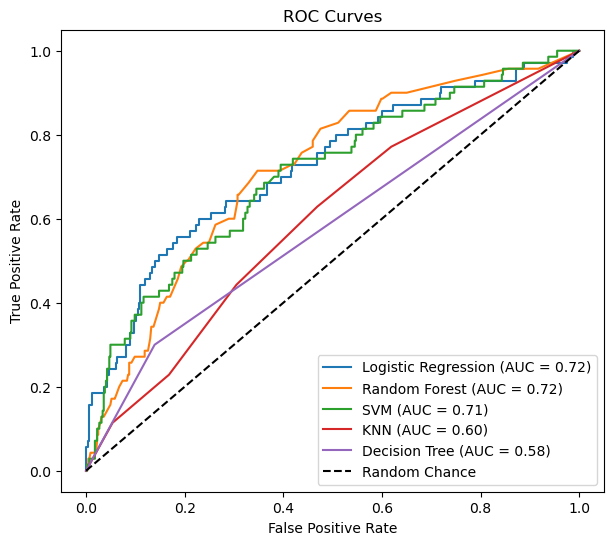

In [67]:
plt.figure(figsize=(7, 6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['ROC-AUC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Conclusion: Choose Logistic Regression as the Model, as this have the most balanced of high Accuracy, Precision, Recall, F1, ROC. And acceptable distributions of True/False Positive/Negative in the Confusion Matrix. 

### Tune the Logistic Regression Model Hyperparameters:
To reduce the percentage of False Positives (Incorrectly appoved loans that should be rejected), but also maintain the high percentage of True Positive: Or Higher Rejcect (1) Recall, and acceptable Approve (0) Recall. 

In [64]:
# Parameter grid for Random Forest Model for suggesting the hyperparameters
param_grid = {
    'C': [0.001, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['liblinear', 'saga', 'lbfgs']
}


# Perform grid search
model = LogisticRegression(max_iter = 10000)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall')
grid_search.fit(X_resampled, y_resampled)
# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


c:\Users\blueb\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
210 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\blueb\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\blueb\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\blueb\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver =

Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best score: 0.7421394719025051


Accuracy: 0.68
              precision    recall  f1-score   support

         0.0       0.93      0.68      0.79       446
         1.0       0.25      0.69      0.37        70

    accuracy                           0.68       516
   macro avg       0.59      0.68      0.58       516
weighted avg       0.84      0.68      0.73       516



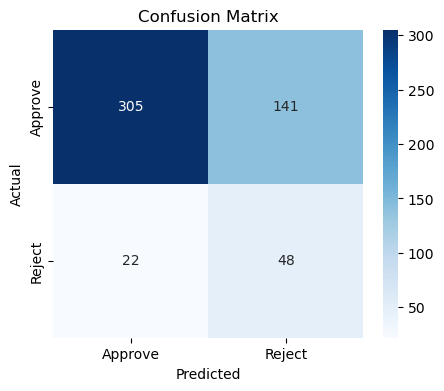

In [65]:
model = LogisticRegression(C = 0.01,
                           penalty = 'l1',
                           solver = 'liblinear',
                           max_iter = 10000)

model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Visualize using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Approve', 'Reject'], yticklabels=['Approve', 'Reject'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()